In [1]:
!pip install pytorch_lightning >/dev/nul
from pytorch_forecasting.data.examples import get_stallion_data
import pandas as pd
import torch
import numpy as npplt
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor
)

from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)

In [28]:
!git clone https://github.com/jdb78/pytorch-forecasting.git
!mv pytorch-forecasting/pytorch_forecasting/ .
!rm -rf pytorch-forecasting/

In [2]:
DATA_DIR = "/content/gdrive/MyDrive/DL-proj/"
DATA_FILE = "data.xlsx"
RANDOM_SEED = 754

MAX_PREDICTION_LENGTH = 15
MIN_PREDICTION_LENGTH = 1
MAX_ENCODER_LENGTH = 60
MIN_ENCODER_LENGTH = MAX_ENCODER_LENGTH // 2

BATCH_SIZE = 32

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
!cp {DATA_DIR + DATA_FILE} /content/

Mounted at /content/gdrive/


In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU available, using cuda.')
    torch.cuda.manual_seed_all(RANDOM_SEED) #for reproducablity
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU available, using cuda.


In [4]:
xl_file = pd.ExcelFile(DATA_FILE)

sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

data = sheets['main']

print('\n', data.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74200 entries, 0 to 74199
Columns: 126 entries, time_idx to negative-comment-embedding19
dtypes: float64(40), int64(84), object(2)
memory usage: 71.3+ MB

 None 



In [5]:
for country in data.country.unique():
    data.loc[data.country == country, 'avg7_confirmed-cases'] =\
     data[data.country==country]['confirmed-cases'].rolling(7).\
                                                    mean().\
                                                    fillna(0).\
                                                    round().\
                                                    astype('int')

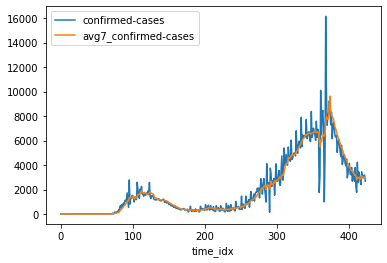

In [6]:
# plt.subplot(2,1/,1)
data[data.country=='Canada'].plot(x='time_idx', y=['confirmed-cases','avg7_confirmed-cases'])
# plt.subplot(2,1,2)
# data[data.country=='Canada'].plot.bar(width=1., y='confirmed-cases',x='time_idx')


In [7]:
# Changing real values of measurements to zero and one categoris

def to_cat(x):
    
    x[x > 0] = "1"
    x[x == 0] = "0"
    
    return x


measures = [i for i in data.columns if 'comment' not in i and ("positive" in i or "negative" in i)]


data[measures] = data[measures].apply(to_cat).astype("category")



In [ ]:
# Removing countires with low number of new cases
avg_threshhold = 500

deleting_countries = []

for country in data.country.unique():
    case_avg = data[data.country == country]['confirmed-cases'].mean()
    if case_avg < avg_threshhold:
        deleting_countries.append(country)
        
print(f'Deleting {len(deleting_countries)} countries from {len(data.country.unique())} countries')

for country in deleting_countries:
    
    # Deleting those countries
    indices = data[data.country == country].index
    data = data.drop(indices)

Deleting 118 countries from 175 countries


In [8]:
# Remoivng all measures
# Removing negative and positive of the comments

not_feature = ['time_idx', 'country', 'region', 'confirmed-cases']
comments = [i for i in data.columns if 'comment' in i]
# com_names = [i[9:] for i in comments]
# data_only_com = data[comments].T.groupby(com_names).sum().T
# data_not_feature = data[not_feature].copy()
# data_not_feature[com_names[:20]] = data_only_com[com_names[:20]]
# data = data_not_feature
# data

In [ ]:
comments = [i for i in data.columns if 'comment' in i]
not_feature = ['time_idx', 'country', 'region', 'confirmed-cases']
data = data[not_feature + comments]

In [11]:
data

,time_idx,country,region,confirmed-cases,positive-Public health measures,positive-Movement restrictions,positive-Governance and socio-economic measures,positive-Social distancing,positive-Lockdown,positive-Humanitarian exemption,positive-Awareness campaigns,positive-Health screenings in airports and border crossings,positive-International flights suspension,positive-Border checks,positive-Strengthening the public health system,positive-Isolation and quarantine policies,positive-Emergency administrative structures activated or established,positive-Surveillance and monitoring,positive-Other public health measures enforced,positive-Border closure,positive-General recommendations,positive-State of emergency declared,positive-Domestic travel restrictions,positive-Limit public gatherings,positive-Limit product imports/exports,positive-Schools closure,positive-Partial lockdown,positive-Changes in prison-related policies,positive-Closure of businesses and public services,positive-Checkpoints within the country,positive-Economic measures,positive-Military deployment,positive-Curfews,positive-Visa restrictions,positive-Requirement to wear protective gear in public,positive-Testing policy,positive-Amendments to funeral and burial regulations,positive-Full lockdown,positive-Lockdown of refugee/idp camps or other minorities,positive-Additional health/documents requirements upon arrival,...,negative-Partial lockdown,negative-Changes in prison-related policies,negative-Closure of businesses and public services,negative-Checkpoints within the country,negative-Economic measures,negative-Military deployment,negative-Curfews,negative-Visa restrictions,negative-Requirement to wear protective gear in public,negative-Testing policy,negative-Amendments to funeral and burial regulations,negative-Full lockdown,negative-Lockdown of refugee/idp camps or other minorities,negative-Additional health/documents requirements upon arrival,negative-Mass population testing,negative-Humanitarian exemptions,negative-Psychological assistance and medical social work,negative-Complete border closure,negative-Obligatory medical tests not related to COVID-19,negative-comment-embedding0,negative-comment-embedding1,negative-comment-embedding2,negative-comment-embedding3,negative-comment-embedding4,negative-comment-embedding5,negative-comment-embedding6,negative-comment-embedding7,negative-comment-embedding8,negative-comment-embedding9,negative-comment-embedding10,negative-comment-embedding11,negative-comment-embedding12,negative-comment-embedding13,negative-comment-embedding14,negative-comment-embedding15,negative-comment-embedding16,negative-comment-embedding17,negative-comment-embedding18,negative-comment-embedding19,avg7_confirmed-cases
0,0,Afghanistan,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Afghanistan,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Afghanistan,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Afghanistan,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Afghanistan,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [29]:
training_cutoff = data['time_idx'].max() - MAX_PREDICTION_LENGTH - 60


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='confirmed-cases',
    group_ids=['country'],
    weight=None,
    min_encoder_length=MIN_ENCODER_LENGTH,
    max_encoder_length=MAX_ENCODER_LENGTH,
    
    min_prediction_idx=MIN_ENCODER_LENGTH,
    
    min_prediction_length=MIN_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=['country', 'region'],
    
    time_varying_known_reals=['time_idx']+comments,

    time_varying_known_categoricals = measures,
    time_varying_unknown_reals = ['confirmed-cases'],     #com_names[:20] + 
    
    target_normalizer=GroupNormalizer(
        groups=["country"],
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
    # randomize_length=False,
)

validation = TimeSeriesDataSet.from_dataset(
    training, 
    data[lambda x: x.time_idx <= training_cutoff + MAX_PREDICTION_LENGTH],
    predict=True, 
    stop_randomization=True
)


/content/pytorch_forecasting/data/encoders.py:621: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


In [30]:
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE,
    num_workers=0                                     
)

val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE*10,
    num_workers=0
)

In [31]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-6,
    patience=10,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lightning_logs')

### Finding Optimal Learning Rate

In [32]:
pl.seed_everything(RANDOM_SEED)
trainer = pl.Trainer(
    gpus = [0],
    gradient_clip_val=0.1,
)

deepar = DeepAR.from_dataset(
    training,
    cell_type='LSTM',
    learning_rate=0.03,

    hidden_size=512,
    rnn_layers=20,
    dropout=0.1,
    reduce_on_plateau_patience=4,
)
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=0.03,
#     hidden_size=512,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=2,
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=256,  # set to <= hidden_size
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     # reduce learning rate if no improvement in validation loss after x epochs
#     reduce_on_plateau_patience=4,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 754
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 5.3 K 
3 | rnn                    | LSTM                   | 41.3 M
4 | distribution_projector | Linear                 | 1.0 K 
------------------------------------------------------------------
41.3 M    Trainable params
0         Non-trainable params
41.3 M    Total params
165.250   Total estimated model params size (MB)


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


suggested learning rate: 0.0001071519305237606


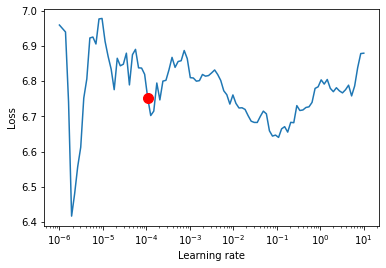

In [33]:
res = trainer.tuner.lr_find(
    # tft,
    deepar,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [34]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# create trainer
trainer = pl.Trainer(
    max_epochs=100,
    gpus=[0],  # train on CPU, use gpus = [0] to run on GPU
    gradient_clip_val=0.1,
    weights_summary='top',
    limit_train_batches=30,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
# initialise model
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=1e-05,
#     hidden_size=50,  # biggest influence network size
#     attention_head_size=1,
#     dropout=0.1,
#     hidden_continuous_size=32,
#     output_size=7,  # QuantileLoss has 7 quantiles by default
#     loss=QuantileLoss(),
#     log_interval=10,  # log example every 10 batches
#     reduce_on_plateau_patience=4,  # reduce learning automatically
# )
deepar = DeepAR.from_dataset(
    training,
    cell_type='LSTM',
    learning_rate=1e-4,

    hidden_size=512,
    rnn_layers=20,
    dropout=0.1,
    reduce_on_plateau_patience=4,
)
# tft.size() # 29.6k parameters in model
# # # fit network
trainer.fit(
    # tft,
    deepar,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 5.3 K 
3 | rnn                    | LSTM                   | 41.3 M
4 | distribution_projector | Linear                 | 1.0 K 
------------------------------------------------------------------
41.3 M    Trainable params
0         Non-trainable params
41.3 M    Total params
165.250   Total estimated model params size (MB)


1

In [ ]:
!ls

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# best_tft

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)
# type(best_tft)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.0 K 
3  | prescalers                         | ModuleDict                      | 384   
4  | static_variable_selection          | VariableSelectionNetwork        | 18.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 52.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.7 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 10.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 10.3 K
9  | static_context_initial_cell_l

/home/m25dehgh/anaconda3/envs/pyforecast/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [35]:
best_tft = deepar
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(2316.7144)

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, return_x=True)


In [36]:
# best_tft.cuda()
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
# best_tft

In [ ]:
raw_predictions

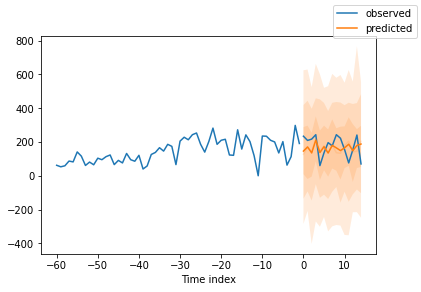

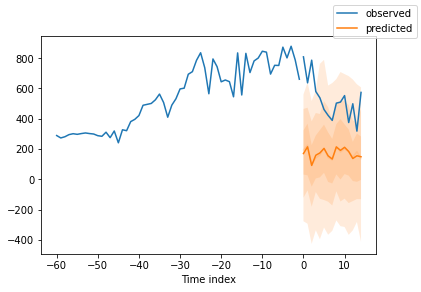

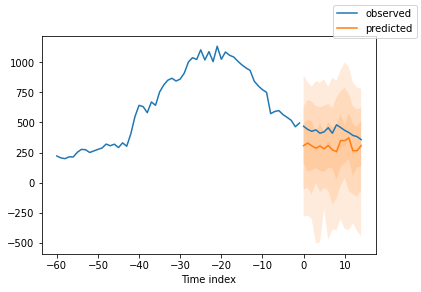

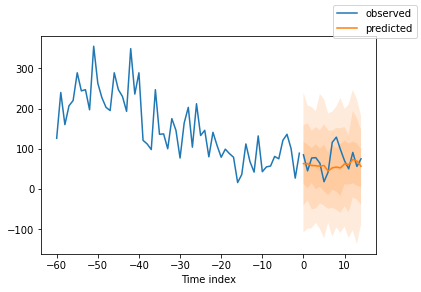

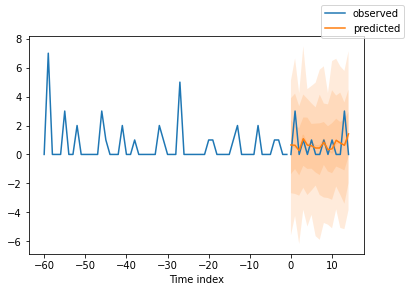

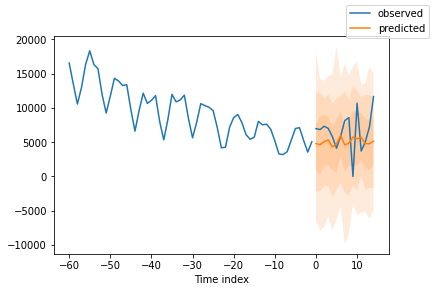

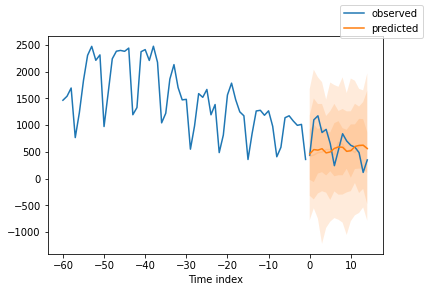

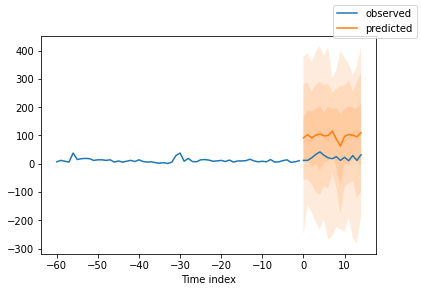

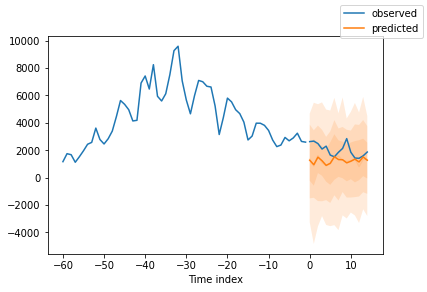

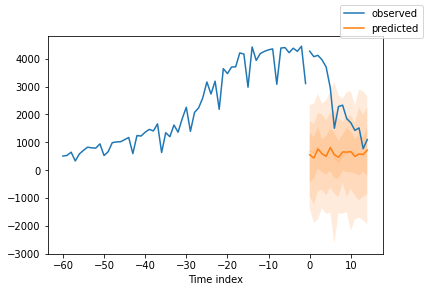

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [18]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)